# Tausworthe, L’Ecuyer, and Mersenne Twister PRN generators

#### Group 4 members: Daniel Solon

<i>*this project is presented as a Python Notebook since it's purely implementation based</i>

## Abstract

For this project, I will be working on the following:

- Implement the Tausworthe, L’Ecuyer, and Mersenne Twister pseudo-random number generators (as described in Module 6 of our notes, with reasonably large values of the parameters $r$, $q$, and $l$ for Tausworthe).

- Plot adjacent PRN’s $(U_i,U_{i+1}), i = 1, 2, . . .$, on the unit square and to see if there are any patterns. Same for adjacent PRN’s $(U_i,U_{i+1},U_{i+2})$ on the unit cube.

- Test the various generators to see if they are actually producing numbers that are approximately independent, identically distributed uniforms. The following hypothesis tests are implemented: 
    - $\chi^2$ goodness-of-fit test for uniformity
    - 'above and below mean' test for independence
    - autocorrelation test for independence

- Compare various generators in terms of run-time efficiency.

From the result of my implementations, I conclude that these generators indeed produce independent and identically distributed (i.i.d.) Unif(0,1)'s. In addition, L'Ecuyer and Mersenne Twister both yield the most pseudo-random numbers (PRNs) per unit
time when compared to Tausworthe.

## Background and Description of the Problem

Probability and statistics are grounded in the abstract notions of probability spaces and random variables. While these foundations have led to a sophisticated and robust mathematical framework, implementing these concepts precisely on conventional computers proves to be unfeasible. Instead, in practice, deterministic algorithms simulate random variables and other random objects. The goal of such algorithms is to generate sequences of numbers or objects that closely mimic the behavior of their "truly random" counterparts, at least within the scope of the intended application [1].

In this project, various generators are implemented to produce pseudo-random numbers which are transformed to Unif(0,1)'s. Hypothesis tests are conducted on these PRNs to confirm uniformity and independence. In addition, run-time with respect to generating 10000 uniforms will be reported. Before I implement the generators, I'll import all the Python libraries needed and define helper functions for plotting and hypothesis testing in the next sub-sections.

## Python libraries

In [1]:
## import utility functions
from tqdm import tqdm # loading
import time # timing

## import libraries for plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## import libraries for computation
from scipy.stats import norm
from scipy.stats import chi2
import numpy as np

## Plotting functions

The following functions plot the generated Uniforms in 2D (square) and in 3D (cube):

In [2]:
## plot 2D Unif(0,1)'s'
def plot_unif(prn):
    U1, U2 = [], []
    
    for i in range(len(prn)-1):
        U1.append(prn[i])
        U2.append(prn[i+1])
  
    plt.scatter(U1, U2)
    plt.title('Generated Uniforms ($U_i$, $U_{i+1}$)')

    
## plot 3D Unif(0,1)'s
def plot_unif_3d(prn):
    U1, U2, U3 = [], [], []
    
    for i in range(len(prn)-2):
        U1.append(prn[i])
        U2.append(prn[i+1])
        U3.append(prn[i+2])

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection='3d')
    ax.scatter3D(U1, U2, U3)
    ax.set_title('Generated Uniforms ($U_i$, $U_{i+1}$, $U_{i+2}$)')

## Hypothesis Test functions

The following functions implement the $\chi^2$ goodness-of-fit test for uniformity, 'above and below mean' test for independence, and autocorrelation test for independence:

In [3]:
## chi-squared goodness-of-fit test for uniformity 
def gof_test(k, unif, alpha):
    intervals = []
    
    ## define intervals
    for i in range(k):
        interval = (i/k, (i+1)/k)
        intervals.append(interval)
    print(f"Intervals: {intervals}")

    ## get expected number of elements per interval
    E_i = len(unif)/k
    print(f"Value of expected number of elements in each bin: {E_i}\n")
    
    ## get counts per interval
    counts = {i:0 for i in range(k)}
    for U in unif:        
        for i, interval in enumerate(intervals):
            if (U >= interval[0] and U < interval[1]):
                counts[i] += 1
                break
    
    ## get test statistic
    chi_2 = 0
    for _, v in counts.items():
        chi_2 += ((v - E_i)**2)/E_i
    print(f"Computed chi-squared test statistic: {chi_2}")
    
    ## get the value for the quantile
    chi_lim = chi2.ppf(1-alpha, k-1)
    print(f"Computed chi-squared quantile with alpha = {alpha}: {chi_lim}\n")
    
    ## decide whether to reject the null hypothesis
    if chi_2 > chi_lim:
        print(f"Since {chi_2} > {chi_lim}, therefore observations are NOT uniform.")
    else:
        print(f"Since {chi_2} < {chi_lim}, therefore we can treat the observations as approximately uniform.")

        
## 'above and below mean' test for independence
def above_below_mean_test(unif, alpha):
    signs = []
    above = 0
    below = 0
    
    ## get counts for above or below 0.5
    for U in unif:
        if U >= 0.5:
            signs.append('+')
            above += 1
        else:
            signs.append('-')
            below += 1
    
    ## count runs
    runs = 1
    for i in range(len(signs) - 2):
        if signs[i] != signs[i+1]:
            runs += 1
    print(f"Number of runs: {runs}\n")        

    ## get mean and variance        
    mu = ((2*above*below) / len(unif)) + 0.5
    var = (2*above*below*(2*above*below - len(unif))) / ((len(unif)**2)*(len(unif) - 1))

    ## get test statistic 
    z_0 = np.abs((runs - mu) / np.sqrt(var))
    print(f"Computed test statistic: {z_0}")
    
    ## get limit statistic
    z_lim = norm.ppf(1 - alpha/2)
    print(f"Computed quantile with alpha = {alpha}: {z_lim}\n")
    
    ## decide whether to reject the null hypothesis
    if z_0 > z_lim:
        print(f"Since {z_0} > {z_lim}, therefore observations are NOT independent.")
    else:
        print(f"Since {z_0} < {z_lim}, therefore we can treat the observations as approximately independent.")
        

## autocorrelation test for independence
def autocorrelation_test(unif, alpha):
    n = len(unif)
        
    ## get rho and it's variance
    temp = 0
    for i in range(n-2):
        temp += unif[i]*unif[i+1]
        
    rho = ((12/(n-1)) * temp) - 3 
    var = (13*n - 19) / ((n-1)**2)
    print(f"Value of rho_hat = {rho} and it's variance = {var}\n")

    ## get test statistic
    z_0 = np.abs(rho/np.sqrt(var))
    print(f"Computed test statistic: {z_0}")

    ## get limit statistic
    z_lim = norm.ppf(1 - alpha/2)
    print(f"Computed quantile with alpha = {alpha}: {z_lim}\n")
    
    ## decide whether to reject the null hypothesis
    if z_0 > z_lim:
        print(f"Since {z_0} > {z_lim}, therefore observations are NOT independent.")
    else:
        print(f"Since {z_0} < {z_lim}, therefore we can treat the observations as approximately independent.")      

## Tausworthe Implementation

The following class implements an XOR function which compares 2 bits based on the parameters $r$, $q$, and the initial bits given as an input. The output from this function returns a bit which is appended at the end of the initial bits. This process can be iterated until a period of $2^q - 1$ which results to a unique sequence of binary numbers. Then, split this sequence into equal groups of $l$ bits. Each group is converted from binary to base 10 and is divided by $2^l$. This process transforms the group of binary numbers to Unif(0,1)'s.

In [4]:
## Tauseworthe generator class
class tauseworthe:
    
    def __init__(self, bits, r, q, l):
        self.bits = bits
        self.r = r
        self.q = q
        self.l = l
        
    ## string-based XOR implementation
    @staticmethod
    def xor(a,b):
        assert(a == '0' or a == '1')
        assert(b == '0' or b == '1')

        if ((a == '0' and b == '0') or (a == '1' and b == '1')):
            return '0'
        
        return '1'

    
    ## generate the next bit by appylying XOR on two bits whose indices are determined by r and q
    def add_bit(self):
        assert(self.r > 0)
        assert(self.q > self.r)
        
        last_idx = len(self.bits) - 1
        self.bits += self.xor(self.bits[last_idx - self.r], self.bits[last_idx - self.q])

        
    ## split bits into groups of 'l'
    def split_bits(self):
        grp = [self.bits[i:i+l] for i in range(0, len(self.bits), l)]
        
        return grp
    
        
    ## generate uniforms    
    def generate_unif(self, grp):
        unif = []
        denom = 2**len(grp[0])
        
        for bit in grp:
            unif.append(int(bit,2) / denom)
        
        return unif

#### Generate and plot Tausworthe Unif(0,1)'s:

100%|███████████████████████████████████████████████████████████████████████| 810000/810000 [00:33<00:00, 24517.66it/s]


Tausworthe elapsed time for generating 10000 Unif(0,1)'s: 33.07856464385986
Plots of the first 500 generated Uniforms using Tausworthe Generator:


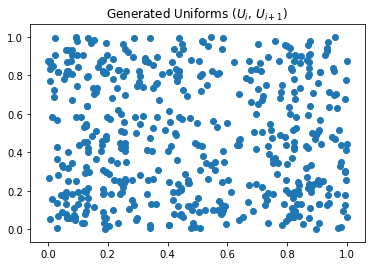

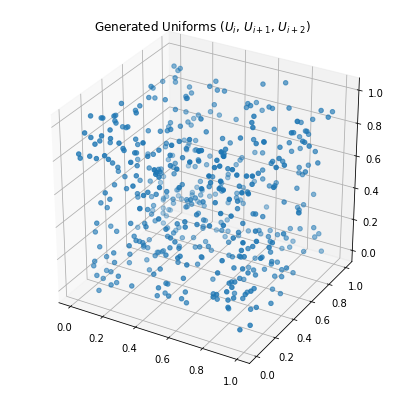

In [5]:
## initialize parameters
r = 26
q = 31 
l = 81 # l-bits to use for PRN to UNIF conversion
init_bits = '1111111111111111111111111111111' # define first q bits

start = time.time()

## generate Tausworthe Unif(0,1)'s
tausworthe_prn = tauseworthe(bits = init_bits, r = r, q = q, l = l)

total = l*10000
for i in tqdm(range(total)): # generate a significant number of PRNs
    tausworthe_prn.add_bit()

tausworthe_unif = tausworthe_prn.generate_unif(tausworthe_prn.split_bits())

end = time.time()
print(f"Tausworthe elapsed time for generating 10000 Unif(0,1)'s: {end-start}")

## plot Tausworthe Unif(0,1)'s
print(f"Plots of the first 500 generated Uniforms using Tausworthe Generator:")
plot_unif(tausworthe_unif[:500])
plot_unif_3d(tausworthe_unif[:500])

From the plots above, no inherent pattern is observed. It's because this generator has a large cycle length of $2^q-1$ where $q=31$. In addition, it takes 30 seconds on average to generate 10000 Unif(0,1)'s. The larger parameter $l$ is, the longer it takes for the algorithm to converge.

####  Conduct hypothesis tests:

In [6]:
## chi-squared goodness of fit test for uniformity
gof_test(k = 5, unif = tausworthe_unif, alpha = 0.05)

Intervals: [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
Value of expected number of elements in each bin: 2000.2

Computed chi-squared test statistic: 2.686131386861314
Computed chi-squared quantile with alpha = 0.05: 9.487729036781154

Since 2.686131386861314 < 9.487729036781154, therefore we can treat the observations as approximately uniform.


In [7]:
## 'above and below mean' test for independence
above_below_mean_test(unif = tausworthe_unif, alpha = 0.05)

Number of runs: 4940

Computed test statistic: 1.21892438774311
Computed quantile with alpha = 0.05: 1.959963984540054

Since 1.21892438774311 < 1.959963984540054, therefore we can treat the observations as approximately independent.


In [8]:
## autocorrelation test for independence
autocorrelation_test(unif = tausworthe_unif, alpha = 0.05)

Value of rho_hat = -0.0036951196594667834 and it's variance = 0.00129994

Computed test statistic: 0.10248654511050422
Computed quantile with alpha = 0.05: 1.959963984540054

Since 0.10248654511050422 < 1.959963984540054, therefore we can treat the observations as approximately independent.


From these test results, I conclude that Tausworthe PRN generator produces i.i.d. Unif(0,1)s.

## L’Ecuyer Implementation

This implementation initializes six values which are used to calculate two values resulting from two unique generators respectively. These two values are used to update some parameters of the unique generators. In addition, the modulo of the difference of these two values with respect to a constant results to a PRN. This PRN is divided by a normalizing factor to generate a Unif(0,1).

In [9]:
## L’Ecuyer generator class
class lecuyer:
    
    def __init__(self, X1_0, X1_1, X1_2, X2_0, X2_1, X2_2):
        ## last 3 PRNs for X1 and X2 calculation for timestep i
        self.state1 = [X1_0, X1_1, X1_2]
        self.state2 = [X2_0, X2_1, X2_2]
    
    def next(self):
        ## update first generator
        X1 = (1403580 * self.state1[1] - 810728 * self.state1[0]) % (2**32 - 209)
        self.state1 = self.state1[-2:] + [X1]
        
        ## update second generator
        X2 = (527612 * self.state2[2] - 1370589 * self.state2[0]) % (2**32 - 22853)
        self.state2 = self.state2[-2:] + [X2]
        
        ## get PRN
        Y = (X1-X2) % (2**32 - 209)
        
        ## return Unif(0.1)
        return Y / (2**32 - 209)

#### Generate and plot L’Ecuyer Unif(0,1)'s:

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 175439.57it/s]


L'Ecuyer elapsed time for generating 10000 Unif(0,1)'s: 0.06820964813232422
Plots of the first 500 generated Uniforms using L'Ecuyer Generator:


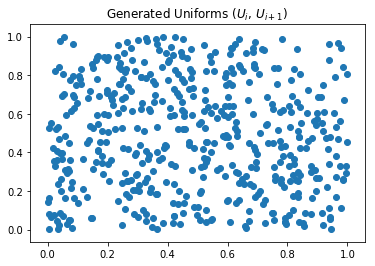

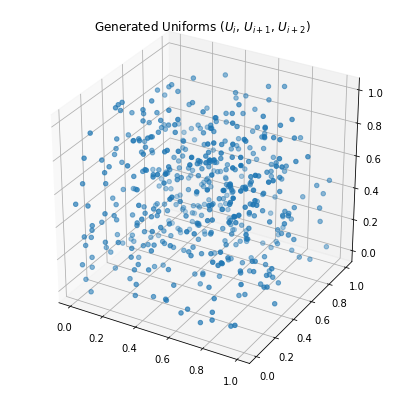

In [10]:
## initialize parameters
X1_0, X1_1, X1_2 = 123456, 234567, 345678
X2_0, X2_1, X2_2 = 987654, 876543, 765432

start = time.time()

## initialize L'Ecuyer generator
lecuyer_prn = lecuyer(X1_0 = X1_0, X1_1 = X1_1, X1_2 = X1_2, X2_0 = X2_0, X2_1 = X2_1, X2_2 = X2_2)
## generate L'Ecuyer Unif(0,1)'s
lecuyer_unif = [lecuyer_prn.next() for _ in tqdm(range(10000))]

end = time.time()
print(f"L'Ecuyer elapsed time for generating 10000 Unif(0,1)'s: {end-start}")

## plot L'Ecuyer Unif(0,1)'s
print(f"Plots of the first 500 generated Uniforms using L'Ecuyer Generator:")
plot_unif(lecuyer_unif[:500])
plot_unif_3d(lecuyer_unif[:500])

From the plots above, no inherent pattern is observed. It's because this generator has a large cycle length of $2^{191}$. In addition, it takes 0.05 seconds on average to generate 10000 Unif(0,1)'s which is faster than Tausworthe's.

####  Conduct hypothesis tests:

In [11]:
## chi-squared goodness of fit test for uniformity
gof_test(k = 5, unif = lecuyer_unif, alpha = 0.05)

Intervals: [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
Value of expected number of elements in each bin: 2000.0

Computed chi-squared test statistic: 2.0229999999999997
Computed chi-squared quantile with alpha = 0.05: 9.487729036781154

Since 2.0229999999999997 < 9.487729036781154, therefore we can treat the observations as approximately uniform.


In [12]:
## 'above and below mean' test for independence
above_below_mean_test(unif = lecuyer_unif, alpha = 0.05)

Number of runs: 5081

Computed test statistic: 1.6112551998732187
Computed quantile with alpha = 0.05: 1.959963984540054

Since 1.6112551998732187 < 1.959963984540054, therefore we can treat the observations as approximately independent.


In [13]:
## autocorrelation test for independence
autocorrelation_test(unif = lecuyer_unif, alpha = 0.05)

Value of rho_hat = -0.038664010733534315 and it's variance = 0.0013000700009995

Computed test statistic: 1.0723178469178267
Computed quantile with alpha = 0.05: 1.959963984540054

Since 1.0723178469178267 < 1.959963984540054, therefore we can treat the observations as approximately independent.


From these test results, I conclude that L’Ecuyer PRN generator produces i.i.d. Unif(0,1)s.

## Mersenne Twister Implementation

This following class initializes an array of 624 numbers which is based from the given seed. Then, this array is updated by the "twist" function  which transforms the values by combining bits of adjacent elements. Then, a PRN is generated in the "temper" function using bit shifts and XOR operations to enhance statistical randomness. This implementation is based from [2].

In [14]:
class MersenneTwister:
    
    def __init__(self, seed):
        ## define constants
        self.w, self.n, self.m, self.f = 32, 624, 397, 1812433253
        self.u, self.s, self.t, self.l = 11, 7, 15, 18
        self.a, self.b, self.c = 0x9908B0DF, 0x9D2C5680, 0xEFC60000
        self.lower, self.upper, self.d = 0x7FFFFFFF, 0x80000000, 0xFFFFFFFF
        
        ## define variable states
        self.pos_index = self.n
        self.MT = [0]*self.n
        
        ## initialize MT array
        self.MT[0] = seed & 0xFFFFFFFF
        for i in range(1, self.n):
            self.MT[i] = (self.f * (self.MT[i-1] ^ (self.MT[i-1] >> (self.w-2))) + i) & self.d
        
        self.twist()

        
    def twist(self):
        for i in range(self.n):
            x = (self.MT[i] & self.upper) + (self.MT[(i+1) % self.n] & self.lower)
            xA = x >> 1
            if((x % 2) != 0):
                xA ^= self.a
            self.MT[i] = self.MT[(i + self.m) % self.n] ^ xA
        self.pos_index = 0

        
    def temper(self):
        ## generate new numbers
        if(self.pos_index >= self.n):
            self.twist()
        
        y = self.MT[self.pos_index]
        y ^= (y >> self.u) & self.d
        y ^= (y << self.s) & self.b
        y ^= (y << self.t) & self.c
        y ^= (y >> self.l)
        
        self.pos_index += 1
        
        return (y & self.d) 

#### Generate and plot Mersenne Twister Unif(0,1)'s:

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 163618.86it/s]


Mersenne Twister elapsed time for generating 10000 Unif(0,1)'s: 0.0723106861114502
Plots of the first 500 generated Uniforms using Mersenne Twister Generator:


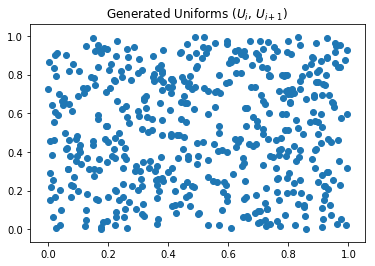

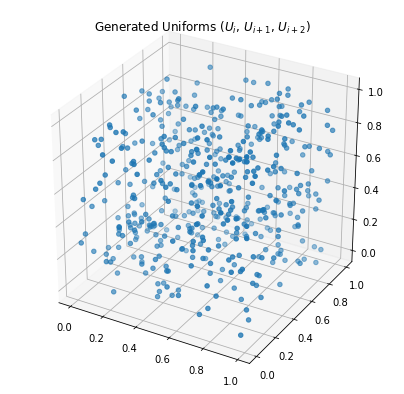

In [15]:
## initialize parameters
seed = 12345

start = time.time()

## initialize Mersenne Twister generator
mt_prn = MersenneTwister(seed=seed)
## generate Mersenne Twister Unif(0,1)'s
mt_unif = [mt_prn.temper()/(2**32) for _ in tqdm(range(10000))]

end = time.time()
print(f"Mersenne Twister elapsed time for generating 10000 Unif(0,1)'s: {end-start}")

## plot Mersenne Twister Unif(0,1)'s
print(f"Plots of the first 500 generated Uniforms using Mersenne Twister Generator:")
plot_unif(mt_unif[:500])
plot_unif_3d(mt_unif[:500])

From the plots above, no inherent pattern is observed. It's because this generator has a large cycle length of $2^{19937}-1$. In addition, it takes 0.05 seconds on average to generate 10000 Unif(0,1)'s which is faster than Tausworthe's and about as fast as L’Ecuyer's.

####  Conduct hypothesis tests:

In [16]:
## chi-squared goodness of fit test for uniformity
gof_test(k = 5, unif = mt_unif, alpha = 0.05)

Intervals: [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
Value of expected number of elements in each bin: 2000.0

Computed chi-squared test statistic: 0.548
Computed chi-squared quantile with alpha = 0.05: 9.487729036781154

Since 0.548 < 9.487729036781154, therefore we can treat the observations as approximately uniform.


In [17]:
## 'above and below mean' test for independence
above_below_mean_test(unif = mt_unif, alpha = 0.05)

Number of runs: 5025

Computed test statistic: 0.5008952274294833
Computed quantile with alpha = 0.05: 1.959963984540054

Since 0.5008952274294833 < 1.959963984540054, therefore we can treat the observations as approximately independent.


In [18]:
## autocorrelation test for independence
autocorrelation_test(unif = mt_unif, alpha = 0.05)

Value of rho_hat = -0.01735475581722401 and it's variance = 0.0013000700009995

Computed test statistic: 0.48132136420005434
Computed quantile with alpha = 0.05: 1.959963984540054

Since 0.48132136420005434 < 1.959963984540054, therefore we can treat the observations as approximately independent.


From these test results, I conclude that Mersenne Twister PRN generator produces i.i.d. Unif(0,1)s.

## Conclusions

All three generators produced independent and identically distributed Unif(0,1)'s. In addition, L'Ecuyer and Marsenne Twister produced the same amount of uniforms, on average, in the same time. On the other hand, Tausworthe produced less uniforms given the same time.

## References

[1] L’Ecuyer, Pierre. Random Number Generation. Département d’Informatique et de Recherche Opérationnelle, Université de Montréal, n.d. Web. http://www.iro.umontreal.ca/~lecuyer.

[2] Matsumoto, Makoto, and Takuji Nishimura. "Mersenne Twister: A 623-Dimensionally Equidistributed Uniform Pseudo-Random Number Generator." ACM Transactions on Modeling and Computer Simulation, vol. 8, no. 1, Jan. 1998, pp. 3–30. https://doi.org/10.1145/272991.272995.